<a href="https://colab.research.google.com/github/Yashmi16/EAI_Assignments/blob/master/Week_5_Lab1_Text_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 5 Lab - Text embeddings

##### Based in part on Tutorial by TensorFlow Authors
##### Copyright 2019 The TensorFlow Authors.

# Word embeddings

This lab introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org).


### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

     |████████████████████████████████| 516.1MB 31kB/s 
     |████████████████████████████████| 460kB 66.8MB/s 
     |████████████████████████████████| 2.8MB 64.0MB/s 
     |████████████████████████████████| 2.9MB 50.1MB/s 
     |████████████████████████████████| 778kB 52.7MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [0]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.



In [0]:

embedding_layer = layers.Embedding(1000, 5)



When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [4]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.00359879,  0.00931659,  0.0374116 , -0.00181966, -0.02100102],
       [-0.04868146, -0.03416611,  0.04714214,  0.04913462, -0.0338742 ],
       [ 0.01488299,  0.04326409, -0.00747199,  0.00157646,  0.03093571]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [5]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Learning embeddings from scratch

In this lab you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.


In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteT7EVFL/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteT7EVFL/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteT7EVFL/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. 

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [7]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews.

In [0]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [9]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 324,   12,  284, ...,    0,    0,    0],
       [7924,   14,   32, ..., 5695,  136, 7975],
       [ 274,    9,  107, ...,    0,    0,    0],
       ...,
       [2892,    7, 1680, ...,    0,    0,    0],
       [2580, 5068,   40, ...,    0,    0,    0],
       [ 249,   37,   51, ...,    0,    0,    0]])

### Create a simple model

We will use the [Keras Sequential API](../../guide/keras) to define our model. In this case it is a "Continuous bag of words" style model.

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [10]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


## Review questions on embedding model
1. What is encoder.vocab_size? What does this number represent? What happens in an input has a word that is not in the encoder vocab?
2. What is the embedding dimension? What does this number represent? 
3. What are the benefits and drawbacks of having a larger embedding dimensionality?

In [11]:
encoder.vocab_size


8185

1. encoder.vocab_size tells how many vocabulary are there in the encoder. In this example, there are 8185 vocabularies in the encoder.

2. Embedding dimension is 16. It represents the size of the vector space that the word will be embedded in which is also the size of output vectors from this layer for each word

3. Larger dimensionality can provide a more semantic models but it would take more computational power

### Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.5056 - accuracy: 0.6959 - val_loss: 0.4016 - val_accuracy: 0.8450
Epoch 2/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2838 - accuracy: 0.8813 - val_loss: 0.3448 - val_accuracy: 0.8450
Epoch 3/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2301 - accuracy: 0.9112 - val_loss: 0.2821 - val_accuracy: 0.8750
Epoch 4/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1988 - accuracy: 0.9258 - val_loss: 0.4360 - val_accuracy: 0.8300
Epoch 5/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1747 - accuracy: 0.9350 - val_loss: 0.4353 - val_accuracy: 0.8500
Epoch 6/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1553 - accuracy: 0.9421 - val_loss: 0.3037 - val_accuracy: 0.8850
Epoch 7/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1452 - accuracy: 0.9470 - val_loss: 0.3400 - val_ac

## Evaluating the model
1. Plot the training and validiation accuracy as a function of training epoch. When does the model start overfitting?

In [13]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

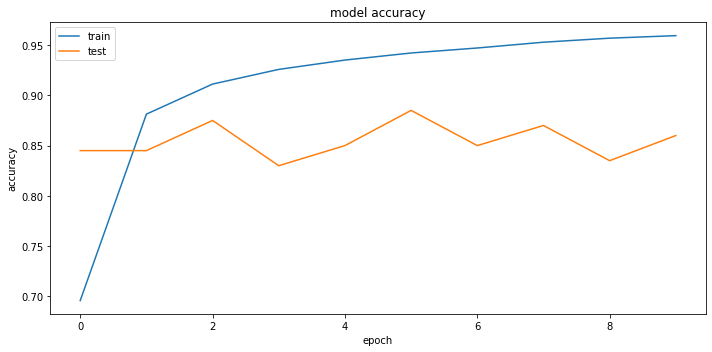

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.tight_layout()

Answer The model starts to underfit after 3 epoch as we can see the gap between training accuracy and testing accuracy is getting larger



## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [0]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Embedding visualizaton questions
1. Load the embedding into the visualizer and search for 4 different words. For each, list the 5 closest neighbors (these are output by the visualizer after you search for a word. Use euclidean distance option). Are these what you would expect for the closest neighbors? Why do you think the embedding for some words is difficult to interpret?
2. Compare the closest neighbors from these same words to the Word2Vec 10k pretrained embedding (available on the visualizer).


# Answer

Different: Various, distinguish, manny, few

amaze: amuse, excite, happy

terrible: disappointing, unfunny, disappointment, pointless, fails


Some of the nearest points are what i expected that as they have similat meaning, however words like gain in bad and jackie in great do not seem right. The words may appear in the same phrase as the label, so the embedding learned the relationship

Compare with Word2Vec

Different: classify, uncommon, countable

amaze: beautify, great, overwhelm

terrible: bad, tragedy, devastating, ivan, suffering

## Bonus Question
Modify the embedding model and/or neural network to improve the accuracy. 

In [19]:
embedding_dim=32

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(32, activation='sigmoid'),
  layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          261920    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 263,009
Trainable params: 263,009
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=20,
    validation_data=test_batches, validation_steps=10)

Epoch 1/20
2500/2500 [==============================] - 18s 7ms/step - loss: 0.5474 - accuracy: 0.6578 - val_loss: 0.4793 - val_accuracy: 0.7700
Epoch 2/20
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3050 - accuracy: 0.8724 - val_loss: 0.3629 - val_accuracy: 0.8600
Epoch 3/20
2500/2500 [==============================] - 17s 7ms/step - loss: 0.2430 - accuracy: 0.9043 - val_loss: 0.4013 - val_accuracy: 0.8600
Epoch 4/20
2500/2500 [==============================] - 17s 7ms/step - loss: 0.2097 - accuracy: 0.9188 - val_loss: 0.5029 - val_accuracy: 0.8600
Epoch 5/20
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1856 - accuracy: 0.9302 - val_loss: 0.3962 - val_accuracy: 0.8500
Epoch 6/20
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1689 - accuracy: 0.9375 - val_loss: 0.2791 - val_accuracy: 0.9000
Epoch 7/20
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1508 - accuracy: 0.9449 - val_loss: 0.4558 - val_ac